## Least-sqaured regression

### Imports

In [100]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-ticks")
from numpy.random import randn
import time
from functools import wraps

C:\Users\Heli\AppData\Local\Temp\ipykernel_11176\60141741.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-ticks")


### Runtime

In [110]:
def runtime(func):
    @wraps(func)
    def runtime_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print("\n", f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return runtime_wrapper

### Values

In [102]:
n = 200 # number of points
sigma = 2
sigma2 = 2*sigma**2
lam = 0.000001

# Approximation parameters
m = 30 # number of samples
w = randn(m) / sigma
b = np.random.rand(m)*2*np.pi

# Example functions
x = randn(n)/2
y=np.cos(x) + randn(n) # randn(n) is noise

x_sort = np.sort(x)

### Gaussian kernel

In [113]:
def k_gauss(x, z): 
    k = np.exp(-((np.linalg.norm(x-z))**2)/(2*sigma**2))
    return k

@runtime
def K_gauss(x, y, n):
    #start_time = time.time()
    Kxy = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            Kxy[i, j] = k_gauss(x[i], y[j])
    #end_time = time.time()
    #print("Execution time: ", end_time - start_time, "seconds")
    return Kxy

K_gauss = K_gauss(x, y, n)
K_gauss

Execution time:  0.30674028396606445 seconds

 Function K_gauss took 0.3065 seconds


array([[0.50082813, 0.88560306, 0.93591605, ..., 0.90143734, 0.80351495,
        0.81747261],
       [0.62086146, 0.95790305, 0.98659123, ..., 0.96778325, 0.89885164,
        0.90962765],
       [0.81927987, 0.99866516, 0.98381343, ..., 0.99604245, 0.99319709,
        0.99593365],
       ...,
       [0.37450226, 0.77252422, 0.84050977, ..., 0.79299196, 0.674776  ,
        0.69062352],
       [0.52953278, 0.9059182 , 0.9514293 , ..., 0.9204499 , 0.82867705,
        0.84198863],
       [0.4034479 , 0.80200335, 0.86650853, ..., 0.82158745, 0.70694924,
        0.72251178]])

#### Alpha

In [104]:
def alpha_gauss(x, y, n):
    start_time = time.time()
    K = K_gauss(x, x, n)
    alpha_gauss = np.linalg.inv(K + lam*np.eye(n)) @ y
    end_time = time.time()
    print("Execution time: ", end_time - start_time, "seconds")
    return alpha_gauss
    
alpha_ = alpha_gauss(x, y, n)

TypeError: 'numpy.ndarray' object is not callable

#### Estimated function

In [ ]:
def function_gauss(x, n, alpha):
    start_time = time.time()
    x_sort = np.sort(x)
    f = np.zeros(n)
    for i in range(n):
        sum = 0
        for j in range(n):
            sum = sum + alpha[j] * k_gauss(x_sort[i], x[j])
        f[i] = sum
    end_time = time.time()
    print("Execution time:", end_time - start_time, "seconds")
    return f

func = function_gauss(x, n, alpha_)

Execution time: 0.7636280059814453 seconds


#### Plot

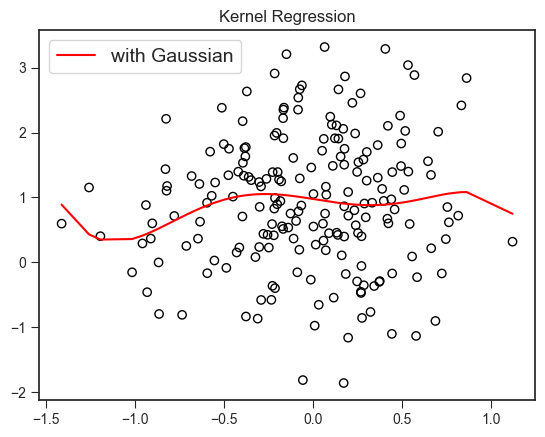

In [ ]:
plt.scatter(x,y, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(x_sort, func, c="r", label="with Gaussian")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
plt.show()

## Random Fourier Features

### Approximation 1

In [ ]:
# Feature vector
def psi(x, w, b):
    return np.sqrt(2)*np.cos(w*x + b)

def k_approx1(x_i, z_i, w, b, m):
    return 1/m * np.sum(psi(x_i, w, b) * psi(z_i, w, b))

# Not in use
def K_approx1(x, z, w, b, m):
    K = np.zeros((n ,m))
    for i in range(n):
        for j in range(m):
            K[i, j] = k_approx1(x[i], z[j], w, b, m)
    return K

K_ = K_approx1(x, x, w, b, m)

#### Alpha

In [ ]:
def alpha_approx1(x, y, lam, w, b, m):
    K = np.zeros((n ,m))
    for i in range(n):
        K[i, :] = psi(x[i], w, b)
    return np.linalg.inv(K.T @ K + lam*np.eye(m)) @ K.T @ y

alpha_approx = alpha_approx1(x, y, lam, w, b, m)

#### Estimated function

In [ ]:
def function_approx1(x, n, alpha):
    x_sort = np.sort(x)
    f = np.zeros(n)
    for i in range(n):
        f[i] = np.sum(alpha*psi(x_sort[i], w, b))
    return f

func_approx1 = function_approx1(x, n, alpha_approx)

#### Plot

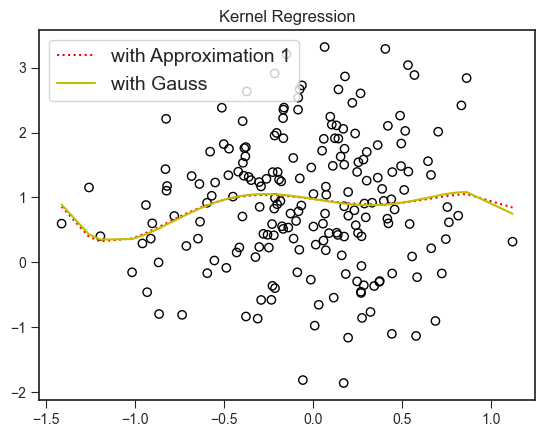

In [ ]:
plt.scatter(x,y, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(x_sort, func_approx1, c="r", label="with Approximation 1", ls = ":")
plt.plot(x_sort, func, c="y", label="with Gauss")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
plt.show()

### Approximation 2

In [ ]:
def psi_cos(x, w, m):
    return 1/np.sqrt(m) * np.cos(w*x)

def psi_sin(x, w, m):
    return 1/np.sqrt(m) * np.sin(w*x)

def k_approx2(x, y, w, m):
    return np.sum(psi_cos(x, w, m)*psi_cos(y, w, m)) + np.sum(psi_cos(x, w, m)*psi_cos(y, w, m))

# Not in use
def K_approx2(x, y, w, n, m):
    K = np.zeros((n, m))
    for i in range(n):
        for j in range(m): 
            K[i, j] = k_approx2(x, y, w, m)
    return K

### Alpha

In [ ]:
def alpha_approx2(x, y, w, n, m):
    K = np.zeros((n, m))
    for i in range(n):
        K[i, :] = psi_cos(x[i], w, m) + psi_sin(x[i], w, m)
    alpha = np.linalg.inv(K.T @ K + lam*np.eye(m)) @ K.T @ y
    return alpha

alpha_2 = alpha_approx2(x, y, w, n, m)

#### Estimated function

In [ ]:
def function_approx2(x, n, alpha):
    x_sort = np.sort(x)
    f = np.zeros(n)
    for i in range(n):
        f[i] = np.sum(alpha*(psi_cos(x_sort[i], w, m) + psi_sin(x_sort[i], w, m)))
    return f

func_approx2 = function_approx2(x, n, alpha_2)

#### Plot

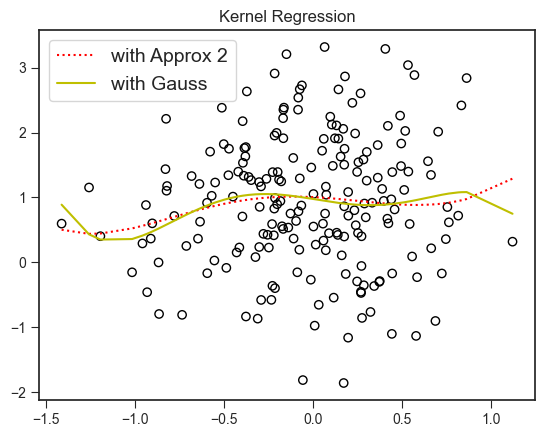

In [ ]:
plt.scatter(x,y, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(x_sort, func_approx2, c="r", label="with Approx 2", ls = ":")
plt.plot(x_sort, func, c="y", label="with Gauss")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
plt.show()

## All plots

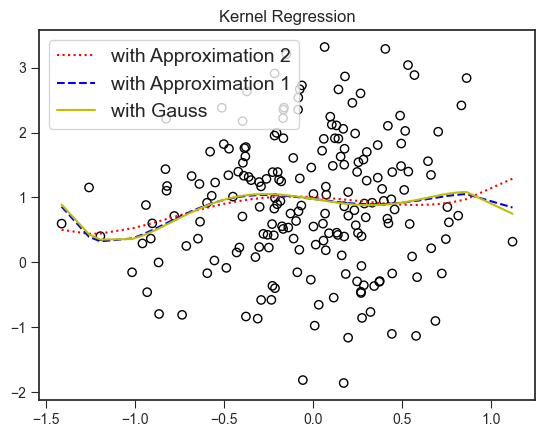

In [ ]:
plt.scatter(x,y, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(x_sort, func_approx2, c="r", label="with Approximation 2", ls = ":")
plt.plot(x_sort, func_approx1, c="b", label="with Approximation 1", ls = "--")
plt.plot(x_sort, func, c="y", label="with Gauss")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
plt.show()